In [56]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [57]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [58]:
NUM_CLASSES = 26

# Dataset reading

In [59]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [60]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [63]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 26)                286       
                                                                 
Total params: 1356 (5.30 KB)
Trainable params: 1356 (5.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [65]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [66]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
124/140 [=========================>....] - ETA: 0s - loss: 3.0345 - accuracy: 0.1045
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
140/140 [==============================] - 1s 4ms/step - loss: 3.0032 - accuracy: 0.1186 - val_loss: 2.6142 - val_accuracy: 0.2778
Epoch 2/1000
 99/140 [====================>.........] - ETA: 0s - loss: 2.5824 - accuracy: 0.2585
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
140/140 [==============================] - 0s 2ms/step - loss: 2.5437 - accuracy: 0.2685 - val_loss: 2.2126 - val_accuracy: 0.4018
Epoch 3/1000
 93/140 [==================>...........] - ETA: 0s - loss: 2.3079 - accuracy: 0.3239
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
140/140 [==============================] - 0s 2ms/step - loss: 2.2581 - accuracy: 0.3377 - val_loss: 1.8150 - val_accuracy: 0.4793
Epoch 4/1000
105/140 [=====================>........] - ETA: 0s - loss: 2.0211 - a

In [67]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

47/47 [==============================] - 0s 1ms/step - loss: 0.6778 - accuracy: 0.8073


In [68]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [69]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 54ms/step
[5.7105756e-01 4.4482886e-06 7.1514951e-06 6.7189007e-06 9.3664676e-03
 3.1825269e-03 1.2342060e-03 2.0529859e-04 3.2259615e-03 1.0610319e-03
 4.5364957e-02 5.2400655e-03 7.6694578e-02 1.0893849e-02 7.2159839e-04
 3.6881545e-06 1.0284173e-06 3.8060804e-03 8.2497746e-02 1.5755855e-02
 6.0027922e-03 1.1259903e-04 3.8554776e-06 1.3670096e-01 2.5541680e-02
 1.3074004e-03]
0


# Confusion matrix

186/186 [==============================] - 0s 823us/step


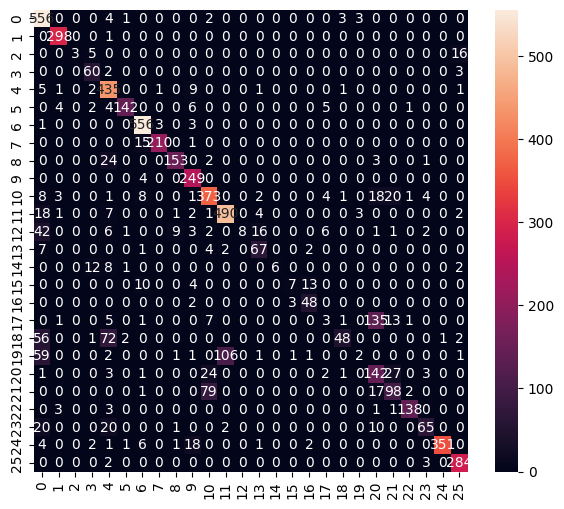

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       569
           1       0.96      1.00      0.98       299
           2       1.00      0.12      0.22        24
           3       0.71      0.92      0.81        65
           4       0.72      0.95      0.82       456
           5       0.96      0.87      0.91       164
           6       0.92      0.99      0.95       563
           7       0.98      0.93      0.95       226
           8       0.92      0.84      0.88       183
           9       0.83      0.98      0.90       253
          10       0.76      0.84      0.80       444
          11       0.82      0.93      0.87       529
          12       1.00      0.08      0.15        97
          13       0.73      0.81      0.77        83
          14       1.00      0.21      0.34        29
          15       0.64      0.21      0.31        34
          16       0.73      0.91      0.81        53
     

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [71]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [72]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpf54ks3j4\assets


INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpf54ks3j4\assets


7564

# Inference test

In [73]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [74]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [75]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [76]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4.54 ms


In [77]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.7105774e-01 4.4482731e-06 7.1514833e-06 6.7188898e-06 9.3664574e-03
 3.1825248e-03 1.2342058e-03 2.0529845e-04 3.2259594e-03 1.0610312e-03
 4.5364957e-02 5.2400497e-03 7.6694548e-02 1.0893834e-02 7.2159822e-04
 3.6881484e-06 1.0284136e-06 3.8060779e-03 8.2497761e-02 1.5755849e-02
 6.0027852e-03 1.1259864e-04 3.8554572e-06 1.3670087e-01 2.5541682e-02
 1.3073976e-03]
0
